In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import warnings 
warnings.filterwarnings('ignore')
from scipy import stats

In [3]:
from datetime import datetime
from pandas import Series
from numpy import log

In [4]:
df = pd.read_csv('/kaggle/input/airline-passengers-forecasting/airline_passengers.csv')
df.head()

,Month,Thousands of Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
df.shape
# 12*12 => 12 years data given

(144, 2)

# Handling missing values as in TSF all rows are dependent

In [6]:
df.isnull().sum()

Month                      0
Thousands of Passengers    0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Month                    144 non-null    object
 1   Thousands of Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [8]:
df.describe()

,Thousands of Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [9]:
df['Month'] = pd.to_datetime(df['Month'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Month                    144 non-null    datetime64[ns]
 1   Thousands of Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [10]:
df.head()

,Month,Thousands of Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


<Axes: >

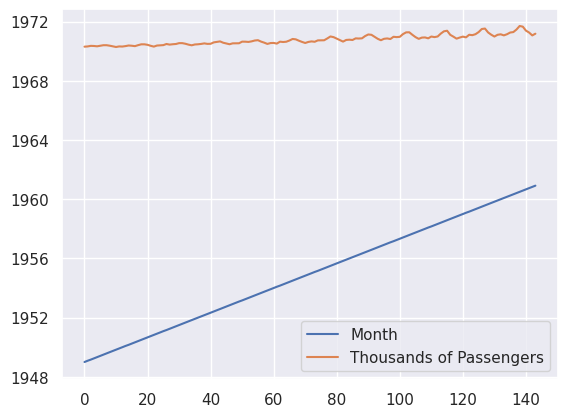

In [11]:
df.plot()

# Converting month as index as it is not a measurable value**

In [12]:
df.shape

(144, 2)

In [13]:
df.set_index('Month',inplace=True)
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [14]:
df.shape

(144, 1)

<Axes: xlabel='Month'>

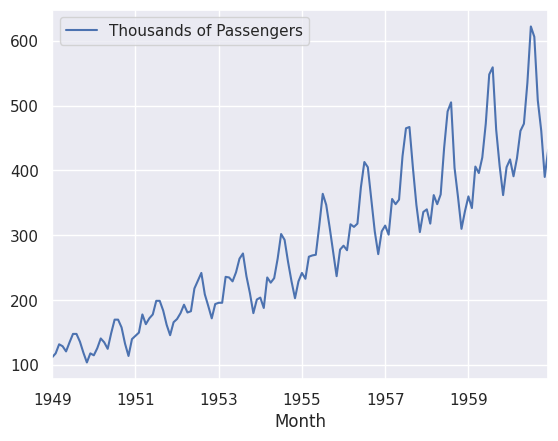

In [15]:
df.plot()

# Upward trend

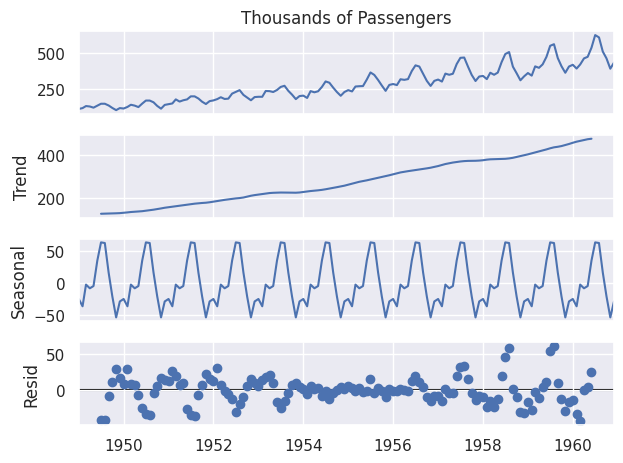

In [16]:
# Decomposition to check dataset component
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df['Thousands of Passengers'], model='additive', period =12)
decompose.plot()
plt.show()

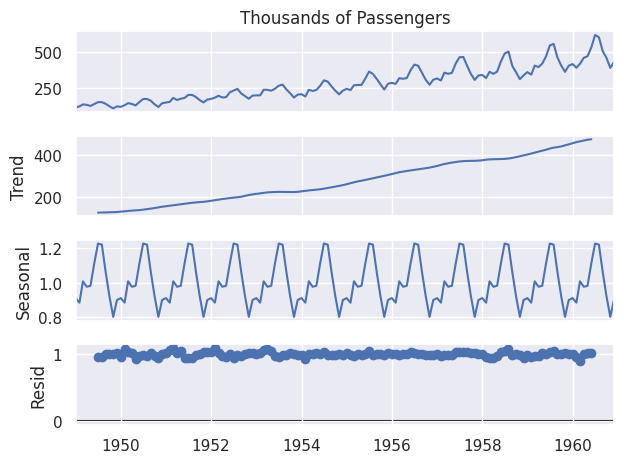

In [17]:
# Decomposition to check dataset component
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df['Thousands of Passengers'], model='multiplicative', period =12)
decompose.plot()
plt.show()

# Checking autocorrelation using Durbin-Waqtson Test

In [18]:
import statsmodels.api as sm
sm.stats.durbin_watson(df['Thousands of Passengers'])

0.0121527966037621

# 0.0121527966037621 << 2 => positive auto correlation, so its as TSF problem 

# Check data is stationary or not

In [19]:
# Augumented Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller
adfuller(df['Thousands of Passengers'])

(0.8153688792060498,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [20]:
def adfuller_test(timeseries):
    result = adfuller(timeseries)
    print(" Augumented Dickey Fuller Test - Check data is stationary or not")
    labels = ['ADF Test Stats', 'P-Value','#Lag', 'No. of Observations']
    
    for i,j in zip(result, labels):
        print(j+ ":->"+ str(i))
        
    if result[1] <=0.05:
        print("Strong evidence against null hypothesis and the time series data is stationary")
    else:
        print("Weak evidence against null hypothesis and the time series data is non-stationary")        

In [21]:
adfuller_test(df['Thousands of Passengers'])

 Augumented Dickey Fuller Test - Check data is stationary or not
ADF Test Stats:->0.8153688792060498
P-Value:->0.991880243437641
#Lag:->13
No. of Observations:->130
Weak evidence against null hypothesis and the time series data is non-stationary


# As trend is there, data is non-stationary .
# Converting into stationary data by calcualting diff b/w current and lag values

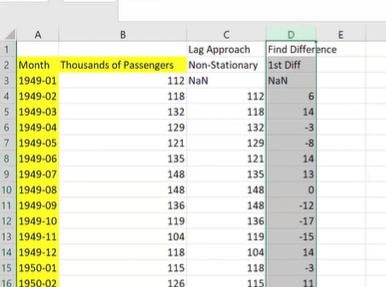

In [22]:
df['1st diff'] = df['Thousands of Passengers'] - df['Thousands of Passengers'].shift(1)
df.head()

,Thousands of Passengers,1st diff
Month,,
1949-01-01,112,NaN
1949-02-01,118,6.0
1949-03-01,132,14.0
1949-04-01,129,-3.0
1949-05-01,121,-8.0


In [23]:
# adfuller_test(df['1st diff'])
adfuller_test(df['1st diff'].dropna())

 Augumented Dickey Fuller Test - Check data is stationary or not
ADF Test Stats:->-2.8292668241700047
P-Value:->0.05421329028382478
#Lag:->12
No. of Observations:->130
Weak evidence against null hypothesis and the time series data is non-stationary


# Still getting non-stationary data (d=1), so calculating 2nd diff

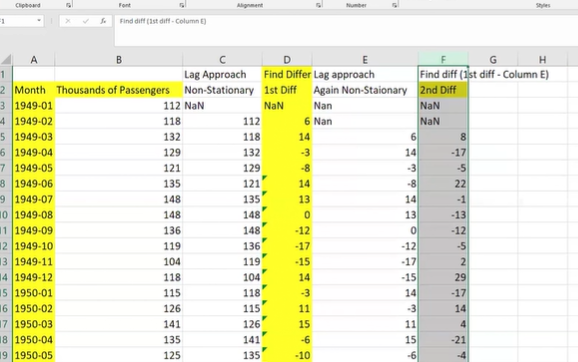

In [24]:
df['2nd diff'] = df['1st diff'] - df['1st diff'].shift(1)
df.head()

,Thousands of Passengers,1st diff,2nd diff
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,6.0,NaN
1949-03-01,132,14.0,8.0
1949-04-01,129,-3.0,-17.0
1949-05-01,121,-8.0,-5.0


In [25]:
adfuller_test(df['2nd diff'].dropna())

 Augumented Dickey Fuller Test - Check data is stationary or not
ADF Test Stats:->-16.384231542468513
P-Value:->2.7328918500142026e-29
#Lag:->11
No. of Observations:->130
Strong evidence against null hypothesis and the time series data is stationary


# getting stationary data for 2nd diff d=2

In [26]:
# paramewters - p d q (Trend)
# d=2

# Calculating Seasonality

In [27]:
df['Seasonality'] = df['Thousands of Passengers'] - df['Thousands of Passengers'].shift(12)
df.sample()

,Thousands of Passengers,1st diff,2nd diff,Seasonality
Month,,,,
1955-03-01,267,34.0,43.0,32.0


In [28]:
df.head(20)

,Thousands of Passengers,1st diff,2nd diff,Seasonality
Month,,,,
1949-01-01,112,NaN,NaN,NaN
1949-02-01,118,6.0,NaN,NaN
1949-03-01,132,14.0,8.0,NaN
1949-04-01,129,-3.0,-17.0,NaN
1949-05-01,121,-8.0,-5.0,NaN
1949-06-01,135,14.0,22.0,NaN
1949-07-01,148,13.0,-1.0,NaN
1949-08-01,148,0.0,-13.0,NaN
1949-09-01,136,-12.0,-12.0,NaN


In [29]:
adfuller_test(df['Seasonality'].dropna())

 Augumented Dickey Fuller Test - Check data is stationary or not
ADF Test Stats:->-3.383020726492481
P-Value:->0.011551493085514952
#Lag:->1
No. of Observations:->130
Strong evidence against null hypothesis and the time series data is stationary


In [30]:
# Trend -
# p:
# d: 2
# q:
    
# Seasonality-
# P:
# D: 1
# Q:



## How to calculate p/P and q/Q?
## p stands for "Partial autocorrelation" - Use autoregressive method 
## q stands for - use basis moving average

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# p = partial auto correclation factor(pacf)
# q =  auto correclation factor(acf)

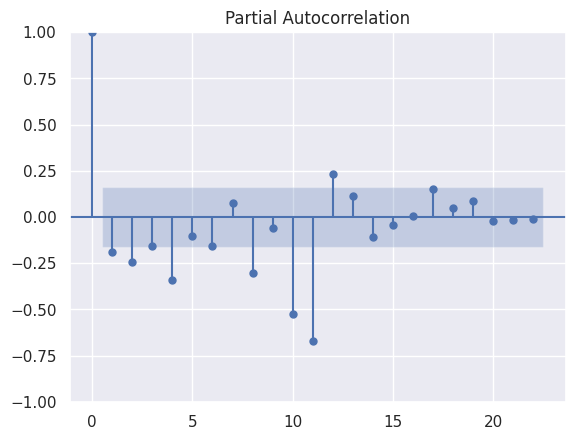

In [32]:
# calcuating p Trend
plot_pacf(df['2nd diff'].dropna())
plt.show()

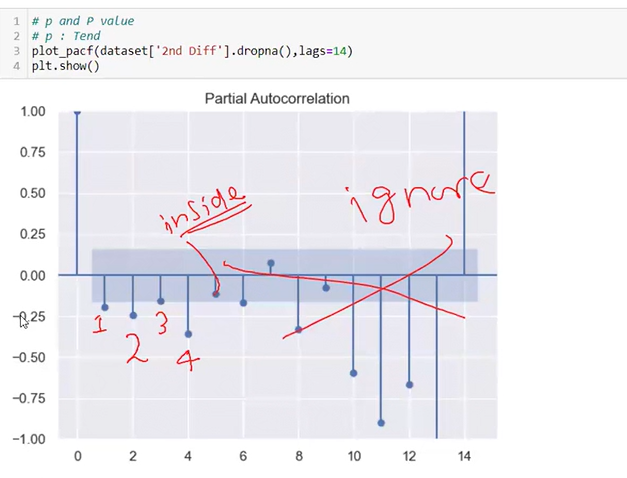

### p=4

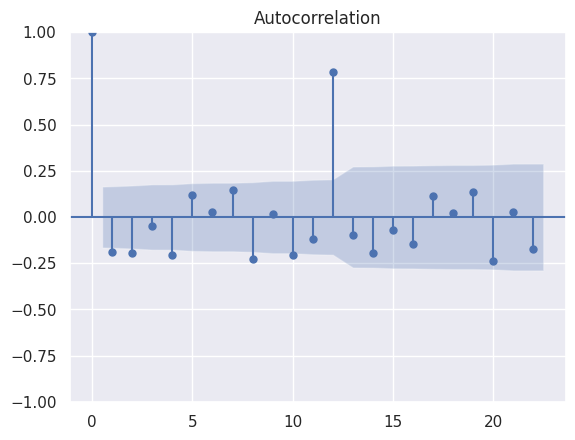

In [33]:
# calcuating q Trend
plot_acf(df['2nd diff'].dropna())
plt.show()

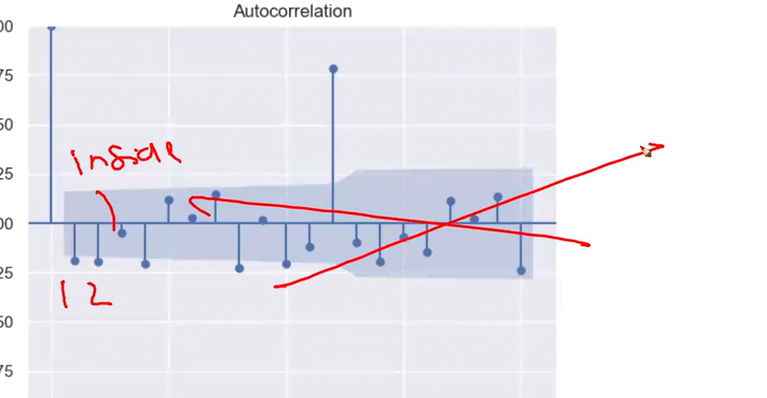

# p=4
# d=2
# q=2

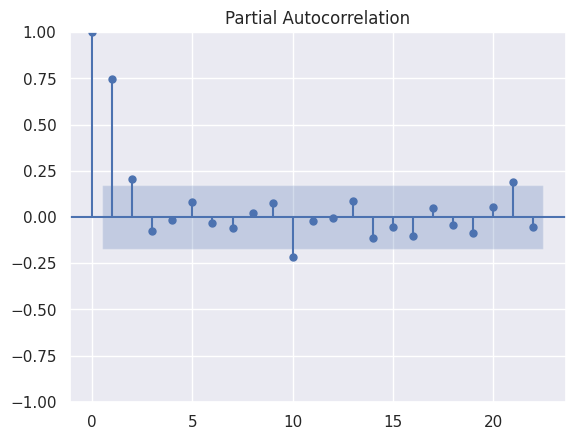

In [34]:
# Seasonality P D Q
# calcuating P
plot_pacf(df['Seasonality'].dropna())
plt.show()

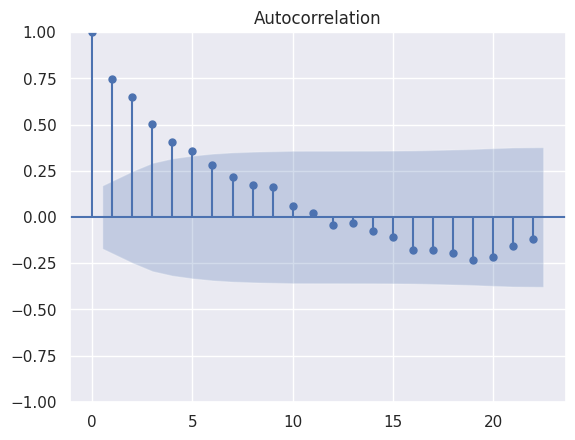

In [35]:
# calcuating Q
plot_acf(df['Seasonality'].dropna())
plt.show()

# Trend
## p=4
## d=2
## q=2

# Seasonality
## P = 2
## D = 1
## Q = 5

# Building TSF 
## ARIMA

In [36]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [37]:
df.head()

,Thousands of Passengers,1st diff,2nd diff,Seasonality
Month,,,,
1949-01-01,112,NaN,NaN,NaN
1949-02-01,118,6.0,NaN,NaN
1949-03-01,132,14.0,8.0,NaN
1949-04-01,129,-3.0,-17.0,NaN
1949-05-01,121,-8.0,-5.0,NaN


In [38]:
#  As external factors affect like rainfall and seasoality is there using SARIMA
model = sm.tsa.statespace.SARIMAX(df['Thousands of Passengers'],order=(4,2,2),
                                 seasonal_order=(2, 1, 5, 12))
result = model.fit()
print(result.summary())

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.82303D+00    |proj g|=  4.28376D-01


 This problem is unconstrained.



At iterate    5    f=  3.52239D+00    |proj g|=  2.76994D-02

At iterate   10    f=  3.46833D+00    |proj g|=  2.41587D-02

At iterate   15    f=  3.45826D+00    |proj g|=  1.21089D-02

At iterate   20    f=  3.45560D+00    |proj g|=  2.70368D-03

At iterate   25    f=  3.45454D+00    |proj g|=  3.45737D-03

At iterate   30    f=  3.45412D+00    |proj g|=  4.95292D-03

At iterate   35    f=  3.45118D+00    |proj g|=  1.34795D-02

At iterate   40    f=  3.45016D+00    |proj g|=  4.91432D-03

At iterate   45    f=  3.44978D+00    |proj g|=  1.71945D-03

At iterate   50    f=  3.44955D+00    |proj g|=  8.90651D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                            SARIMAX Results                                             
Dep. Variable:                          Thousands of Passengers   No. Observations:                  144
Model:             SARIMAX(4, 2, 2)x(2, 1, [1, 2, 3, 4, 5], 12)   Log Likelihood                -496.736
Date:                                          Fri, 15 Nov 2024   AIC                           1021.471
Time:                                                  11:12:59   BIC                           1061.617
Sample:                                              01-01-1949   HQIC                          1037.784
                                                   - 12-01-1960                                         
Covariance Type:                                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar

# AIC -                            1021.471    || SARIMAX(4, 2, 2)x(2, 1, [1, 2, 3, 4, 5], 12)   
### we taken Q=5, it is suggesting to use anyn value among [1, 2, 3, 4, 5 ] and check

# AIC -  1021.471 ,   Q=5
# AIC -  1020.039 ,   Q=4
# AIC -  1018.476 ,   Q=3
# AIC -  1017.565 ,   Q=2
# AIC -  1015.566 ,   Q=1 --- Best model 


In [39]:
#  As external factors affect like rainfall and seasoality is there using SARIMA
model = sm.tsa.statespace.SARIMAX(df['Thousands of Passengers'],order=(4,2,2),
                                 seasonal_order=(2, 1, 1, 12))
result = model.fit()
print(result.summary())

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.82440D+00    |proj g|=  4.74010D-01


 This problem is unconstrained.



At iterate    5    f=  3.53230D+00    |proj g|=  2.97576D-02

At iterate   10    f=  3.49314D+00    |proj g|=  3.31745D-02

At iterate   15    f=  3.47530D+00    |proj g|=  2.65275D-02

At iterate   20    f=  3.46054D+00    |proj g|=  6.63265D-03

At iterate   25    f=  3.45819D+00    |proj g|=  4.16113D-03

At iterate   30    f=  3.45698D+00    |proj g|=  8.09314D-04

At iterate   35    f=  3.45688D+00    |proj g|=  1.19288D-03

At iterate   40    f=  3.45685D+00    |proj g|=  1.29803D-03

At iterate   45    f=  3.45683D+00    |proj g|=  1.12306D-03

At iterate   50    f=  3.45683D+00    |proj g|=  1.39874D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:              Thousands of Passengers   No. Observations:                  144
Model:             SARIMAX(4, 2, 2)x(2, 1, [1], 12)   Log Likelihood                -497.783
Date:                              Fri, 15 Nov 2024   AIC                           1015.566
Time:                                      11:13:08   BIC                           1044.241
Sample:                                  01-01-1949   HQIC                          1027.218
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3591      0.097    -14.043      0.000      -1.549      -1.169
ar.L2         -0.49

In [40]:
len(df)

144

In [41]:
# taking last 14 months for validation (130 - 144)
df['forecast'] = result.predict(start=130, end = 144, dynamic=True)

In [42]:
df.tail(20)

,Thousands of Passengers,1st diff,2nd diff,Seasonality,forecast
Month,,,,,
1959-05-01,420,24.0,34.0,57.0,NaN
1959-06-01,472,52.0,28.0,37.0,NaN
1959-07-01,548,76.0,24.0,57.0,NaN
1959-08-01,559,11.0,-65.0,54.0,NaN
1959-09-01,463,-96.0,-107.0,59.0,NaN
1959-10-01,407,-56.0,40.0,48.0,NaN
1959-11-01,362,-45.0,11.0,52.0,355.675410
1959-12-01,405,43.0,88.0,68.0,388.271177
1960-01-01,417,12.0,-31.0,57.0,404.232755


<Axes: xlabel='Month'>

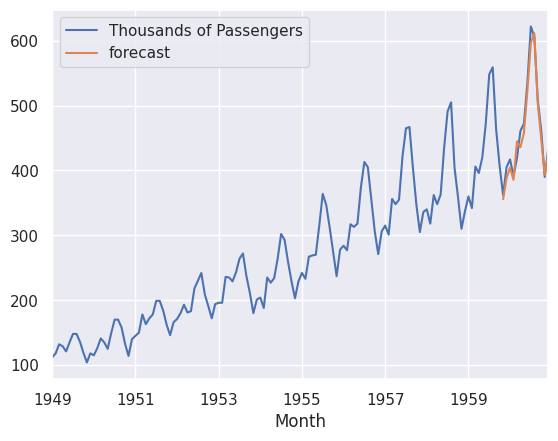

In [43]:
df[['Thousands of Passengers','forecast']].plot()

### Forecasting for next 10 years 

In [44]:
from pandas.tseries.offsets import DateOffset
future_date = [df.index[-1] + DateOffset(months=x) for x in range (0,121)]
df.index[-1]

Timestamp('1960-12-01 00:00:00')

In [45]:
len(df)

144

In [46]:
future_date

[Timestamp('1960-12-01 00:00:00'),
 Timestamp('1961-01-01 00:00:00'),
 Timestamp('1961-02-01 00:00:00'),
 Timestamp('1961-03-01 00:00:00'),
 Timestamp('1961-04-01 00:00:00'),
 Timestamp('1961-05-01 00:00:00'),
 Timestamp('1961-06-01 00:00:00'),
 Timestamp('1961-07-01 00:00:00'),
 Timestamp('1961-08-01 00:00:00'),
 Timestamp('1961-09-01 00:00:00'),
 Timestamp('1961-10-01 00:00:00'),
 Timestamp('1961-11-01 00:00:00'),
 Timestamp('1961-12-01 00:00:00'),
 Timestamp('1962-01-01 00:00:00'),
 Timestamp('1962-02-01 00:00:00'),
 Timestamp('1962-03-01 00:00:00'),
 Timestamp('1962-04-01 00:00:00'),
 Timestamp('1962-05-01 00:00:00'),
 Timestamp('1962-06-01 00:00:00'),
 Timestamp('1962-07-01 00:00:00'),
 Timestamp('1962-08-01 00:00:00'),
 Timestamp('1962-09-01 00:00:00'),
 Timestamp('1962-10-01 00:00:00'),
 Timestamp('1962-11-01 00:00:00'),
 Timestamp('1962-12-01 00:00:00'),
 Timestamp('1963-01-01 00:00:00'),
 Timestamp('1963-02-01 00:00:00'),
 Timestamp('1963-03-01 00:00:00'),
 Timestamp('1963-04-

In [47]:
future_dates = pd.DataFrame( index= future_date[1:], columns = df.columns)
df.tail()

,Thousands of Passengers,1st diff,2nd diff,Seasonality,forecast
Month,,,,,
1960-08-01,606,-16.0,-103.0,47.0,611.517992
1960-09-01,508,-98.0,-82.0,45.0,503.452823
1960-10-01,461,-47.0,51.0,54.0,448.460093
1960-11-01,390,-71.0,-24.0,28.0,393.195017
1960-12-01,432,42.0,113.0,27.0,426.480450


In [48]:
len(future_dates)

120

In [49]:
future_dates.tail(120)

,Thousands of Passengers,1st diff,2nd diff,Seasonality,forecast
1961-01-01,NaN,NaN,NaN,NaN,NaN
1961-02-01,NaN,NaN,NaN,NaN,NaN
1961-03-01,NaN,NaN,NaN,NaN,NaN
1961-04-01,NaN,NaN,NaN,NaN,NaN
1961-05-01,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1970-08-01,NaN,NaN,NaN,NaN,NaN
1970-09-01,NaN,NaN,NaN,NaN,NaN
1970-10-01,NaN,NaN,NaN,NaN,NaN
1970-11-01,NaN,NaN,NaN,NaN,NaN


In [50]:
final_date = pd.concat([df,future_dates])
len(final_date)

264

In [51]:
final_date.tail(121)

,Thousands of Passengers,1st diff,2nd diff,Seasonality,forecast
1960-12-01,432,42.0,113.0,27.0,426.48045
1961-01-01,NaN,NaN,NaN,NaN,NaN
1961-02-01,NaN,NaN,NaN,NaN,NaN
1961-03-01,NaN,NaN,NaN,NaN,NaN
1961-04-01,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1970-08-01,NaN,NaN,NaN,NaN,NaN
1970-09-01,NaN,NaN,NaN,NaN,NaN
1970-10-01,NaN,NaN,NaN,NaN,NaN
1970-11-01,NaN,NaN,NaN,NaN,NaN


In [52]:
df['forecast1'] = result.predict(start=144, end = 264, dynamic=True)